<a href="https://colab.research.google.com/github/agustinparada/Fisica_Computacional_I/blob/master/Actividad_11/Actividad11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Actividad 11***

José Agustín Parada Peralta

Departamento de Física

Universidad de Sonora

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from numpy import linspace, zeros
from scipy.integrate import odeint
from scipy.fftpack import diff as psdiff
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy
import numpy as np

%matplotlib inline
plt.style.use('bmh')

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1990656/45929032 bytes (4.3%)4677632/45929032 bytes (10.2%)7757824/45929032 bytes (16.9%)10895360/45929032 bytes (23.7%)13828096/45929032 bytes (30.1%)17047552/45929032 bytes (37.1%)19824640/45929032 bytes (43.2%)22650880/45929032 bytes (49.3%)25444352/45929032 bytes (55.4%)28360704/45929032 bytes (61.7%)31285248/45929032 bytes (68.1%)34177024/45929032 bytes (74.4%)

# ***Ecuación de onda***
La ecuación de onda tridimensional es:

$$ \frac{\partial^2u}{\partial t^2}=c^2\nabla^2u +f(\vec{x},t)$$

Donde $\nabla^2u$ es el operador Laplaciano de la función de onda $u$ para 3 dimensiones.

En el caso particular de una dimensión (una cuerda), la ecuación es:
$$ \frac{\partial^2u}{\partial t^2}=c^2\frac{\partial^2u}{\partial x^2}+f(x,t) $$

Aplicando el método de diferencias finitas obtenemos una manera de resolución aproximada. Si definimos $u(x,t) = u(nh,mk) = u_n^m$, la expresión del método queda:

$$ u_n^{m+1}=2u_n^m-u_n^{m-1}+Q^2(u_{n+1}^m-2u_n^m+u_{n-1}^m) + k^2f$$

Donde $Q^2 = \dfrac{k^2}{h^2}c^2 $, a su vez $\Delta x = h;\; \Delta t = k$. $Q$ se conoce como la constante de Courant.

Para iniciarlizar el método, utilizamos (pues no es posible aplicar la expresión anterior en el tiempo correspondiente a $m=1$) diferencias finitas de primer orden centradas para la derivada temporal de $u_n^0$:

$$ \frac{\partial}{\partial t}u_m^0 = \frac{u_m^1-u_m^{-1}}{2k} = 0 $$

De donde se tiene que $u_m^1 = u_m^{-1}$, sustituyendo en la expresión de diferencias finitas de segundo orden:

$$ u_n^1 = u_n^0+\frac{Q^2}{2}(u_{n+1}^0-2u_n^0+u_{n-1}^0) + k^2f_n^1$$

# ***Problema 1***
Utilizar el método de diferencias finitas para resolver la ecuación de la onda:
$$ \frac{\partial^2u}{\partial t^2}+b\frac{\partial u}{\partial t} = c^2 \left(\frac{\partial^2u}{\partial x^2}\right) $$
Donde $b \geq 0;\; c$ son constantes.

Se tienen las condiciones iniciales y de frontera:

\begin{align*}
u(x,0) &= I(x)=x(1-x)\\
\frac{\partial}{\partial t}u(x,0) &= 0 \\
u(0,t) &= 0\\
u(L,t) &= 0\\
\end{align*}

Aplicando el método de diferencias finitas de segundo orden y despejando $u_n^{m+1}$ obtenemos:
$$ u_n^{m+1}=\frac{1}{\alpha}(2u_n^m-\beta u_n^{m-1}+Q^2(u_{n+1}^m-2u_n^m+u_{n-1}^m)) $$

Donde $\alpha = 1+\dfrac{bk}{2};\; \beta = 1- \dfrac{bk}{2};\; Q^2 = \dfrac{k^2}{h^2}c^2$

Luego, para el primer paso obtenemos la expresión:

$$ u_n^1 = u_n^0+\frac{Q^2}{2}(u_{n+1}^0-2u_n^0+u_{n-1}^0) $$

Utilizar las constantes:
\begin{align*}
L &=10\\
c &= 100\: m/s\\
t & \in (0,0.25)\\
b &= 0.5\\
\end{align*}

In [ ]:
# Definimos la función solucionador de la ecuación de onda
def sol1(I, V, c, b, L, Nx, T, Nt, user_action=None):
    # Resuelve u_tt+b*u_t=c^2*u_xx + f sobre (0,L)x(0,T].
    x = linspace(0, L, Nx+1) # Malla en x
    dx = x[1] - x[0]
    t = linspace(0, T, Nt+1) # Malla en t
    dt= t[1]-t[0]
    a = b*dt/2+1             # Simplificación para el algoritmo
    beta = 1-b*dt/2          # Simplificación para el algoritmo
    C2 = (dt*c/dx)**2        # Simplificar la ecuación
    
    if V is None or V == 0:
        V = lambda x: 0
    u = zeros(Nx+1) # Solución al nuevo tiempo
    u_1 = zeros(Nx+1) # Solución 1 paso atrás en el tiempo
    u_2 = zeros(Nx+1) # Solución 2 pasos atrás en el tiempo

    # Cargar la condición inicial en u_1
    for i in range(0,Nx+1):
        u_1[i] = I(x[i])

    if user_action is not None:
        user_action(u_1, x, t, 0)
    
    # Fórmula del primer paso m = 0
    for i in range(1, Nx):
        u[i] = u_1[i] + dt*V(x[i]) + \
        0.5*C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1])
    u[0] = 0; u[Nx] = 0
    
    if user_action is not None:
        user_action(u, x, t, 1)
    
    # Redefinimos variables para volver a utilizar
    u_2[:], u_1[:] = u_1, u
    
    for n in range(1, Nt):
        # Actualiza los valores en el tiempo t[n+1]
        for i in range(1, Nx):
            u[i] = (1/a)*(2*u_1[i]-beta*u_2[i]+C2*(u_1[i+1]-2*u_1[i]+u_1[i-1]))
        # Definimos la condición a la frontera
        u[0] = 0; u[Nx] = 0

        if user_action is not None:
            if user_action(u, x, t, n+1):
                break

        # Redefinimos variables antes del siguiente paso
        u_2[:], u_1[:] = u_1, u
    return u, x, t

def user_action(u, x, t, n):
    # Define una acción del usuario para guardar y visualizar posteriormente los datos.
    global user_data
    if 'x' not in user_data:
        user_data['x'] = x
    if 'u' not in user_data:
        user_data['u'] = [(n, u)]
    else:
        user_data['u'].append((t[n], u.copy()))

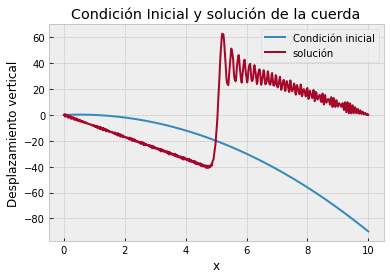

In [ ]:
# Definimos los parámetros que utilizaremos para la resolución de la ecuación 
# mediante diferencias finitas
L=10      # Longitud de la cuerda
c=100     # Velocidad de la onda (m/s)
b=0.5     # Constante de amortiguamiento
Nx=500    # Número de pasos en x
Nt=2000   # Número de pasos temporales
T=0.25    # Tiempo final

user_data={}
# Guardamos la información de la solución y graficamos al tiempo final
u, x, t = sol1(lambda x: x*(1-x), None, c, b, L, Nx, T, Nt, user_action=user_action)
I=x*(1-x)
plt.xlabel('x')
plt.ylabel('Desplazamiento vertical')
plt.title('Condición Inicial y solución de la cuerda')
plt.plot(x,I, label='Condición inicial')
plt.plot(x,u, label='solución')
plt.legend()
plt.show()

In [ ]:
# Duración del video (segundos)
duration = 20
# Tamaño de la gráfica
fig, ax = plt.subplots(figsize=(4, 3), facecolor='white', dpi=92)
plt.tight_layout()
plt.grid(None)

# Creación de cada frame aparente
def make_frame_mpl(t):
    n = int(t / duration * (len(user_data['u']) - 1))
    ax.clear()
    x = user_data['x']
    t, u = user_data['u'][n]
    ax.plot(x, u, color='darkgreen')
    ax.set_title('t = {:.2f}'.format(t))
    ax.set_ylim(-80, 80)
    ax.set_xlabel('x (a. u.)')
    ax.set_ylabel('Desplazamiento vertical (a. u.)')
    return mplfig_to_npimage(fig) # imágen de la figura

# Creación de la animación
animation = mpy.VideoClip(make_frame_mpl, duration=duration)
plt.close(fig)
animation.ipython_display(fps=20, width=600)

100%|█████████▉| 400/401 [00:34<00:00, 11.74it/s]


# ***Problema 2***
Al igual que el inciso anterior, se utilizará el método de diferencias finitas añadiendo un término de forzamiento $f(x,t)$. Tenemos la ecuación:
$$ \frac{\partial^2u}{\partial t^2}= c^2\frac{\partial^2u}{\partial x^2}+f(x,t) $$

Aplicando diferencas finitas, obtenemos:
$$ u_n^{m+1} = 2u_n^m-u_n^{m-1}+Q^2(u_{n+1}^m-2u_n^m+u_{n-1}^m)+k^2f_n^m $$

Donde $f_n^m = f(nh, mk)$.

El método del primer paso queda:
$$ u_n^1 = u_n^0+\frac{Q^2}{2}(u_{n+1}^0-2u_n^0+u_{n-1}^0)+\frac{k^2}{2}f_n^0 $$

Utilizando:
\begin{align*}
u(x,0) &= I(x)=x(1-x)\\
\frac{\partial}{\partial t}u(x,0) &= 0 \\
u(0,t) &= 0\\
u(L,t) &= 0\\
L &=10\\
c &= 100\: m/s\\
t & \in (0,0.25)\\
b &= 0.5\\
\end{align*}

La función de forzamiento se propone como:
$$ f(x,t) = 20e^{pt}\cos{(qx)} $$

In [ ]:
# Definición de la función de solución
def sol2(I, V, f, c, b, L, Nx, T, Nt, user_action=None):
    # Resuelve u_tt + b*u_t=c^2*u_xx + f sobre (0,L)x(0,T].
    x = linspace(0, L, Nx+1) # Malla en x
    dx = x[1] - x[0]
    t = linspace(0, T, Nt+1) # Malla en t
    dt= t[1]-t[0]
    C2 = (dt*c/dx)**2 # Simplificar la ecuación
    
    # Ajuste para la función de forzamiento
    if f is None or f == 0 :
        f = lambda x, t: 0
    
    # Ajuste para condiciones de frontera
    if V is None or V == 0:
        V = lambda x: 0
    u = zeros(Nx+1) # Solución al nuevo tiempo
    u_1 = zeros(Nx+1) # Solución 1 paso atrás en el tiempo
    u_2 = zeros(Nx+1) # Solución 2 pasos atrás en el tiempo

    # Cargar la condición inicial en u_1
    for i in range(0,Nx+1):
        u_1[i] = I(x[i])

    if user_action is not None:
        user_action(u_1, x, t, 0)
    
    # Fórmula del primer paso n = 0
    for i in range(1, Nx):
        u[i] = u_1[i] + \
        0.5*C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) + \
        0.5*dt**2*f(x[i], 0)
    u[0] = 0; u[Nx] = 0
    
    if user_action is not None:
        user_action(u, x, t, 1)
    
    # Redefinimos variables para volver a utilizar
    u_2[:], u_1[:] = u_1, u
    
    for n in range(1, Nt):
        # Actualiza los valores en el tiempo t[n+1]
        for i in range(1, Nx):
            u[i] = 2*u_1[i]-u_2[i]+C2*(u_1[i+1]-2*u_1[i]+u_1[i-1])+dt**2*f(x[i], t[n])
        # Definimos la condición a la frontera
        u[0] = 0; u[Nx] = 0

        if user_action is not None:
            if user_action(u, x, t, n+1):
                break

        # Redefinimos variables antes del siguiente paso
        u_2[:], u_1[:] = u_1, u

    return u, x, t

def user_action(u, x, t, n):
    # Define una acción del usuario para guardar y visualizar posteriormente los datos.
    global user_data
    if 'x' not in user_data:
        user_data['x'] = x
    if 'u' not in user_data:
        user_data['u'] = [(n, u)]
    else:
        user_data['u'].append((t[n], u.copy()))

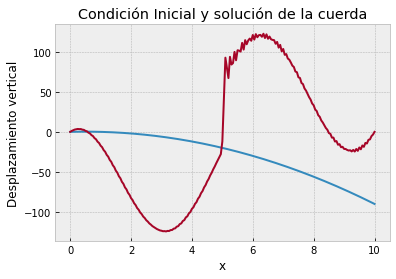

In [ ]:
# Definición de parámetros y valores necesarios para la resolución de la 
# ecuación de onda.
L=10     # límite superior de x
c=100    # Velocidad de la onda (m/s)
Nx=200   # Pasos en x
Nt=501   # Pasos en el tiempo
T=0.25   # Tiempo final de simulación

# Resolvemos la ecuación y graficamos la solución en el tiempo T
user_data={}
u, x, t = sol2(lambda x: x*(1-x), None, lambda x, t: 20*np.cos(x)*np.exp(43*t), c, b, L, Nx, T, Nt, user_action=user_action)
I=x*(1-x)
plt.xlabel('x')
plt.ylabel('Desplazamiento vertical')
plt.title('Condición Inicial y solución de la cuerda')
plt.plot(x,I)
plt.plot(x,u)

In [ ]:
# Duración de la animación (seg)
duration = 20

# Definimos el tamaño de la figura
fig, ax = plt.subplots(figsize=(4, 3), facecolor='white', dpi=92)
plt.tight_layout()
plt.grid(None)

# Creación de los frames
def make_frame_mpl(t):
    n = int(t / duration * (len(user_data['u']) - 1))
    ax.clear()
    x = user_data['x']
    t, u = user_data['u'][n]
    ax.plot(x, u, color='darkmagenta')
    ax.set_title('t = {:.2f}'.format(t))
    ax.set_ylim(-120, 120)
    ax.set_xlabel('x (a. u.)')
    ax.set_ylabel('Desplazamiento vertical (a. u.)')
    return mplfig_to_npimage(fig) # imágen de la figura

# Creación de la animación
animation = mpy.VideoClip(make_frame_mpl, duration=duration)
plt.close(fig)
animation.ipython_display(fps=20, width=600)

100%|█████████▉| 400/401 [00:30<00:00, 12.98it/s]


# ***Problema 3***
La ecuación de Korteweg - De Vries (KdV) describe la propagación de una onda en un medio superficial y viene dada por:

$$ \frac{\partial u}{\partial t}+6u\frac{\partial u}{\partial x} + \frac{\partial^3 u}{\partial x^3} = 0 $$

Resolveremos por medio de la función SciPy.fft.diff (dominio periódico).

Utilizaremos las condiciones:
\begin{align*}
L &=200.0\\
N_x &=2^n;\; n\in \mathbb{N}\\
T &=200 \\
N_t &= 501\\
x_1 &=0.25L\\
x_2 &=0.75L\\
c_1 &=0.75\\
c_2 &= 0.01\\
\end{align*}

Calculando la solución.
Graficando una representación de la interacción de 2 ondas solitarias.


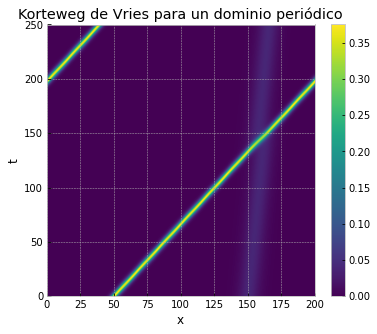

In [ ]:
def kdv_exact(x, c):
    # Solución exacta de la Ecuación KdV: 1 solitón sobre el eje real
    u = 0.5*c*np.cosh(0.5*np.sqrt(c)*x)**(-2)
    return u

def kdv(u, t, L):
    # Las ecuaciones diferenciales de la ecuación KdV, discretizada en x
    # Calcula las derivadas en x usando un método pseudoespectral (Transformada de Fourier)
    # Supone tener condiciones periódicas en la dirección x
    ux = psdiff(u, period=L)
    uxxx = psdiff(u, period=L, order=3)

    # Calcula el lado derecho de la ecuación de KdV 
    dudt = -6*u*ux - uxxx
    return dudt

def kdv_solution(u0, t, L):
    # Utiliza la función odeint para integrar la ecuación KdV sobre un dominio periódico.
    # `u0` es la condición inicial, `t` es el arreglo de tiempos en los que se evaluará la ecuación, 
    # y `L` es el tamaño del dominio periódico en x

    sol = odeint(kdv, u0, t, args=(L,), mxstep=5000)
    return sol

# Define el tamaño del dominio y crea una malla discretizada.
L = 200.0
# Preferentemente N=potencia de 2^n (exigencia de la transformada rápida de Fourier FFT)
Nx = 256

dx = L / (Nx - 1.0) # dx < 0.8
x = np.linspace(0, (1-1.0/Nx)*L, Nx) # L < N

# Definir las condiciones iniciales
# Dos solitones (ondas solitarias) viajando hacia la derecha en un dominio periódico
# Un soliton a la izquierda del otro. Posicionados en x-x01 y x-x02, 
# Con velocidades c1 > c2 que provocará que colisionen entre si (el primero alcance al segundo)
x01 = 0.25*L
x02 = 0.75*L
c1= 0.75
c2= 0.08
u0 = kdv_exact(x-x01, c1) + kdv_exact(x-x02, c2) #+ kdv_exact(x02+L/10-x, 0.9*c2)
    
# Definir el tamaño del dominio en el tiempo
# Tiempo final T
T = 250
Nt = 501
t = np.linspace(0, T, Nt)

print("Calculando la solución.")
sol = kdv_solution(u0, t, L)

print("Graficando una representación de la interacción de 2 ondas solitarias.")

plt.figure(figsize=(6,5))
plt.imshow(sol[::-1, :], extent=[0,L,0,T])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.axis('auto')
plt.title('Korteweg de Vries para un dominio periódico')
plt.show()

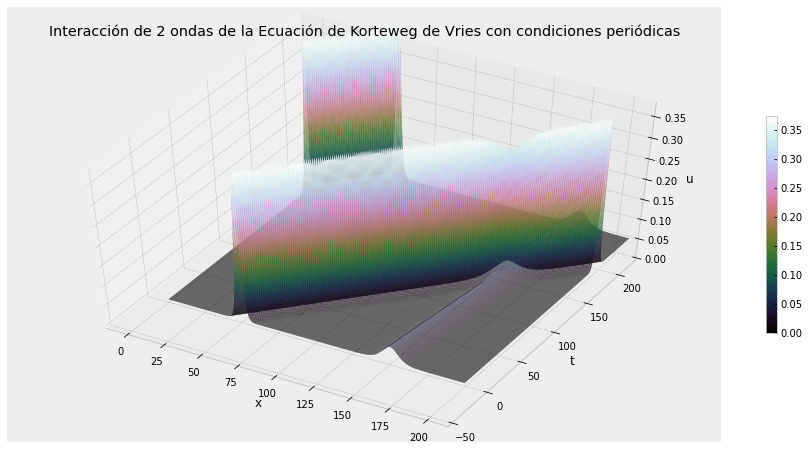

In [ ]:
# Creación de la figura (área del gráfico)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')

SX, ST = np.meshgrid(x, t)
# Ver mapa de colores de Matplotlib
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
ax.plot_surface(SX, ST, sol, cmap='cubehelix', rstride=1, cstride=1, alpha=0.75)

# Grafica una tabla de valores 
m = cm.ScalarMappable(cmap='cubehelix')
m.set_array(sol)
plt.colorbar(m,shrink=0.5)

# Ajustes del gráfico
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
ax.set_ylim(-50,220)
ax.view_init(elev=50, azim=-60)
ax.set_title('Interacción de 2 ondas de la Ecuación de Korteweg de Vries con condiciones periódicas')
plt.show()

# ***Problema 4***

Resolveremos para el caso de tres solitones, con los siguientes inicios:
\begin{align*}
x_1 &= 0.25L\\
x_2 &= 0.50L\\
x_3 &= 0.75L\\
\end{align*}

Así, tenemos, también, las velocidades:
\begin{align*}
c_1 &= 0.75\\
c_2 &= 0.50\\
c_3 &= 0.25\\
\end{align*}

Calculando la solución.
Graficando una representación de la interacción de 2 ondas solitarias.


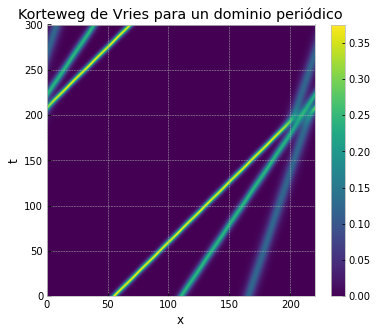

In [ ]:

def kdv_exact(x, c):
    # Perfil de la solución exacta de la Ecuación KdV: 1 solitón sobre el eje real
    u = 0.5*c*np.cosh(0.5*np.sqrt(c)*x)**(-2)
    return u

def kdv(u, t, L):
    # Las ecuaciones diferenciales de la ecuación KdV, discretizada en x
    # Calcula las derivadas en x usando un método pseudoespectral (Transformada de Fourier)
    # Supone tener condiciones periódicas en la dirección x
    ux = psdiff(u, period=L)
    uxxx = psdiff(u, period=L, order=3)

    # Calcula el lado derecho de la ecuación de KdV 
    dudt = -6*u*ux - uxxx
    return dudt

def kdv_solution(u0, t, L):
    # Utiliza la función odeint para integrar la ecuación KdV sobre un dominio periódico.
    # `u0` es la condición inicial, `t` es el arreglo de tiempos en los que se evaluará la ecuación, 
    # y `L` es el tamaño del dominio periódico en x

    sol = odeint(kdv, u0, t, args=(L,), mxstep=5000)
    return sol


# Define el tamaño del dominio y crea una malla discretizada.
L = 220.0
# Preferentemente N=potencia de 2^n (exigencia de la transformada rápida de Fourier FFT)
Nx = 256

dx = L / (Nx - 1.0) # dx < 0.8
x = np.linspace(0, (1-1.0/Nx)*L, Nx) # L < N

# Definir las condiciones iniciales
# Dos solitones (ondas solitarias) viajando hacia la derecha en un dominio periódico
# Un soliton a la izquierda del otro. Posicionados en x-x01 y x-x02, 
# Con velocidades c1 > c2 que provocará que colisionen entre si (el primero alcance al segundo)
x01 = 0.25*L
x02 = 0.50*L
x03 = 0.75*L
c1= 0.75
c2= 0.50
c3 = 0.25
u0 = kdv_exact(x-x01, c1) + kdv_exact(x-x02, c2) + kdv_exact(x-x03, c3) #+ kdv_exact(x02+L/10-x, 0.9*c2)
    
# Definir el tamaño del dominio en el tiempo
# Tiempo final T
T = 300
Nt = 501
t = np.linspace(0, T, Nt)
print("Calculando la solución.")
sol = kdv_solution(u0, t, L)

print("Graficando una representación de la interacción de 2 ondas solitarias.")

# Ajustes de la gráfica 2-d
plt.figure(figsize=(6,5))
plt.imshow(sol[::-1, :], extent=[0,L,0,T])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.axis('auto')
plt.title('Korteweg de Vries para un dominio periódico')
plt.show()

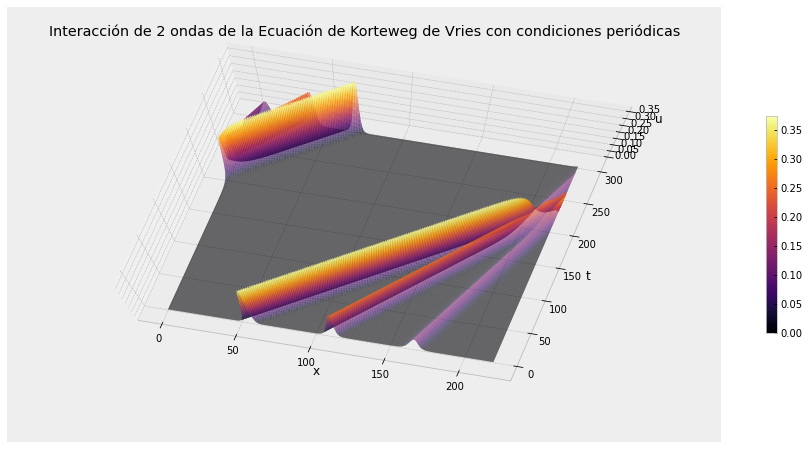

In [ ]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')

SX, ST = np.meshgrid(x, t)
# Ver mapa de colores de Matplotlib
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
ax.plot_surface(SX, ST, sol, cmap='inferno', rstride=1, cstride=1, alpha=0.75)

# Grafica una tabla de valores 
m = cm.ScalarMappable(cmap='inferno')
m.set_array(sol)
plt.colorbar(m,shrink=0.5)

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
ax.view_init(elev=80, azim=-75)
ax.set_title('Interacción de 2 ondas de la Ecuación de Korteweg de Vries con condiciones periódicas')
plt.show()

# ***Problema 5***

Se resolverá la ecuación:
$$ \frac{\partial^2 u}{\partial t^2} = \frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2} $$

Mediante diferencias finitas. Utilizando la condición inicial:

$$ u_0^{(1,1)}(x,y,0) = \sin{\left( \frac{\pi x}{2} \right)}\sin{\left( \frac{\pi y}{2} \right)} $$

N: 200
D: 0.25
Mx: 50
My 50
dx,dy; 0.04 0.04
nsteps: 200


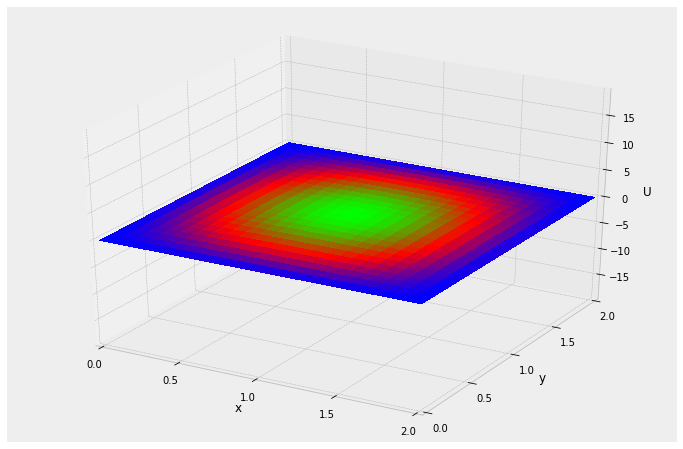

paso: 10.0 t= 0.285


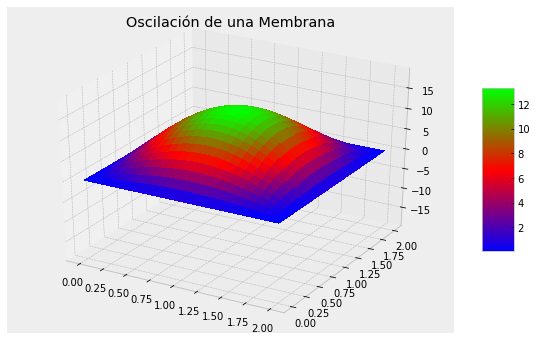

paso: 20.0 t= 0.585


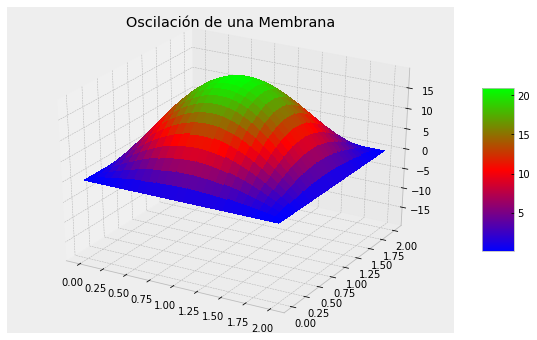

paso: 30.0 t= 0.885


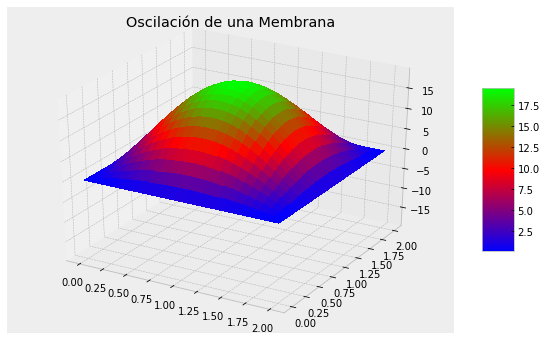

paso: 40.0 t= 1.185


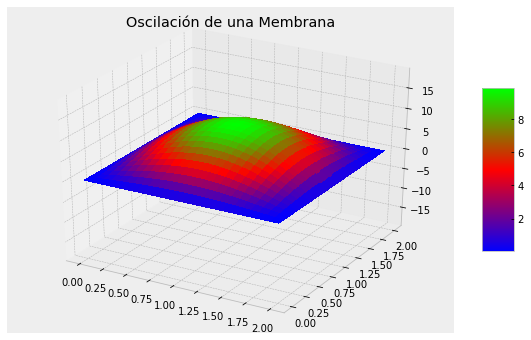

paso: 50.0 t= 1.4849999999999999


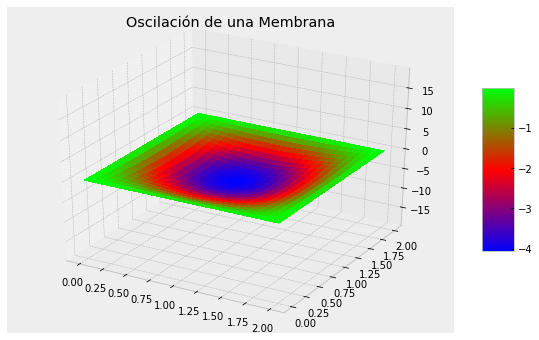

paso: 60.0 t= 1.785


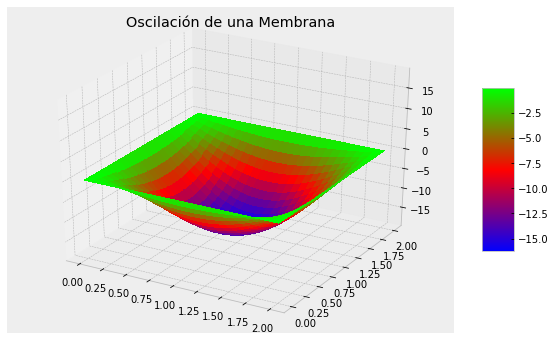

paso: 70.0 t= 2.085


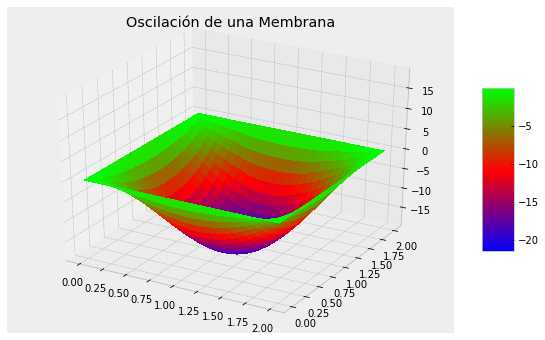

paso: 80.0 t= 2.385


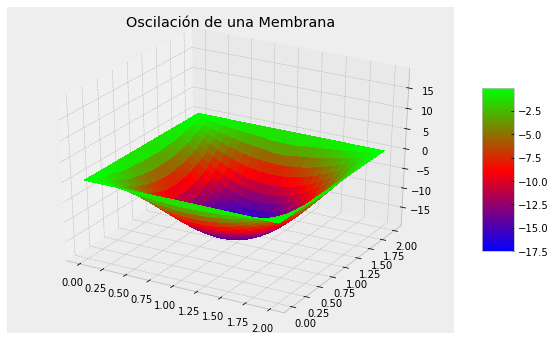

paso: 90.0 t= 2.685


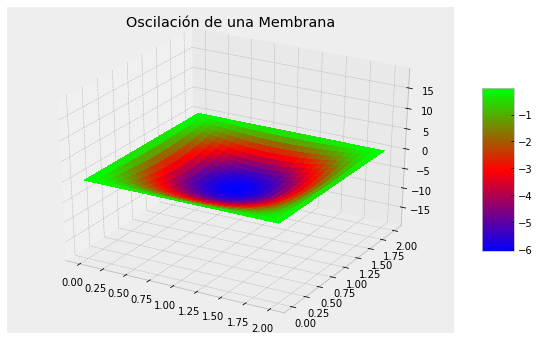

paso: 100.0 t= 2.985


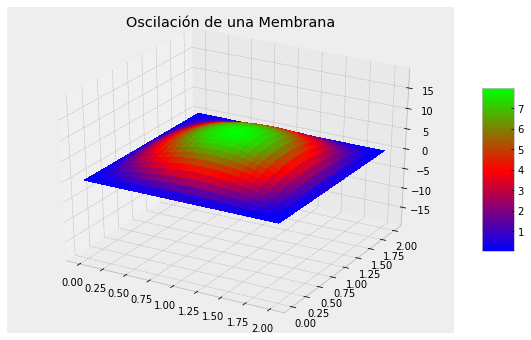

In [7]:
# Se define la Clase general que incluye todas las funciones
class WaveEquationFD:
    
    def __init__(self, N, D, Mx, My):
        self.N = N
        print('N:',N)
        self.D = D
        print('D:',D)
        self.Mx = Mx
        print('Mx:',Mx)
        self.My = My
        print('My',My)
        self.tend = 6
        self.xmin = 0
        self.xmax = 2
        self.ymin = 0
        self.ymax = 2
        self.initialization()
        self.eqnApprox()
           
    def initialization(self):
        self.dx = (self.xmax - self.xmin)/self.Mx
        self.dy = (self.ymax - self.ymin)/self.My
        print('dx,dy;',self.dx,self.dy)
        
        self.x = np.arange(self.xmin, self.xmax+self.dx, self.dx)
        self.y = np.arange(self.ymin, self.ymax+self.dy, self.dy)
        
        #----- Initial condition -----#
        self.u0 = lambda r, s: np.sin(np.pi*r/2)*np.sin(np.pi*s/2)
        
        #----- Initial velocity -----#
        self.v0 = lambda a, b: 0
        
        #----- Boundary conditions -----#
        self.bxyt = lambda left, right, time: 0
        
        self.dt = (self.tend - 0)/self.N
        self.t = np.arange(0, self.tend+self.dt/2, self.dt)
        
        # Assertion for the condition of r < 1, for stability
        r = 4*self.D*self.dt**2/(self.dx**2+self.dy**2);
        assert r < 1, "r is bigger than 1!"

            
    def eqnApprox(self):
        #----- Approximation equation properties -----#
        self.rx = self.D*self.dt**2/self.dx**2
        self.ry = self.D*self.dt**2/self.dy**2
        self.rxy1 = 1 - self.rx - self.ry 
        self.rxy2 = self.rxy1*2

        #----- Initialization matrix u for solution -----#
        self.u = np.zeros((self.Mx+1, self.My+1))
        self.ut = np.zeros((self.Mx+1, self.My+1))
        self.u_1 = self.u.copy()
        
        #----- Fills initial condition and initial velocity -----#
        for j in range(1, self.Mx):
            for i in range(1, self.My):
                self.u[i,j] = self.u0(self.x[i], self.y[j])
                self.ut[i,j] = self.v0(self.x[i], self.y[j])
        
    
    def solve_and_animate(self):
        
        u_2 = np.zeros((self.Mx+1, self.My+1))
        
        xx, yy = np.meshgrid(self.x, self.y)
         
        fig = plt.figure(figsize=(12,8))        
        ax = fig.add_subplot(111, projection='3d')
        #ax = plt.axes(projection ='3d')
        
        wframe = None
        
        k = 0
        nsteps = self.N
        print('nsteps:',nsteps)
        
        while k < nsteps:
            if wframe:
                ax.collections.remove(wframe)
                
            self.t = k*self.dt
            
            #----- Fills in boundary condition along y-axis (vertical, columns 0 and Mx) -----#
            for i in range(self.My+1):
                self.u[i, 0] = self.bxyt(self.x[0], self.y[i], self.t)
                self.u[i, self.Mx] = self.bxyt(self.x[self.Mx], self.y[i], self.t)
                
            for j in range(self.Mx+1):
                self.u[0, j] = self.bxyt(self.x[j], self.y[0], self.t)
                self.u[self.My, j] = self.bxyt(self.x[j], self.y[self.My], self.t)
                
            if k == 0:
                for j in range(1, self.My):
                    for i in range(1, self.Mx):
                        self.u[i,j] = 0.5*(self.rx*(self.u_1[i-1,j] + self.u_1[i+1,j])) \
                                + 0.5*(self.ry*(self.u_1[i,j-1] + self.u_1[i,j+1])) \
                                + self.rxy1*self.u[i,j] + self.dt*self.ut[i,j]
            else:
                for j in range(1, self.My):
                    for i in range(1, self.Mx):
                        self.u[i,j] = self.rx*(self.u_1[i-1,j] + self.u_1[i+1,j]) \
                            + self.ry*(self.u_1[i,j-1] + self.u_1[i,j+1]) \
                            + self.rxy2*self.u[i,j] - u_2[i,j]
                            
            u_2 = self.u_1.copy()
            self.u_1 = self.u.copy()

            wframe = ax.plot_surface(xx, yy, self.u, cmap=cm.brg, linewidth=2, 
                    antialiased=False)
            
            ax.set_xlim3d(0, 2.0)
            ax.set_ylim3d(0, 2.0)
            ax.set_zlim3d(-19, 19)
            
            ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0])
            ax.set_yticks([0, 0.5, 1.0, 1.5, 2.0])
            
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("U")
            
            plt.pause(0.05)
            k += 0.5
            
            # Sección añadida para hacer gráficas cada 15 pasos 
            if (k < 101 and k%10 == 0):
                print('paso:',k, 't=', self.t)
                # Creating figure
                fig2 = plt.figure(figsize =(10, 6))
                ax2 = plt.axes(projection ='3d')
                # Creating color map
                my_cmap = plt.get_cmap('coolwarm')
                # Creating plot
                surf = ax2.plot_surface(xx, yy, self.u, cmap=cm.brg, linewidth=2, 
                    antialiased=False)
                fig.colorbar(surf, ax = ax2,
                    shrink = 0.5, aspect = 5)
                ax2.set_zlim(-19,19)
                ax2.set_title('Oscilación de una Membrana')
                # show plot
                plt.show()

# Se definen los parámetros con los que se va a ejecutar el código     
# N pasos de integración, parámetro de estabilidad < 0.5, Num.Puntos x, Núm.Puntos y

def main():
    simulator = WaveEquationFD(200, 0.25, 50, 50)
    simulator.solve_and_animate() 
    plt.show()
    
if __name__ == "__main__":
    main()

# ***Problema 6***

Se resolverá la misma ecuación con una distinta condición inicial:

$$ u_0^{(3,1)+(1,3)} = \sin{\left( \frac{3\pi x}{2} \right)}\sin{\left( \frac{\pi y}{2} \right)}+\sin{\left( \frac{\pi x}{2} \right)}\sin{\left( \frac{3\pi y}{2} \right)} $$

N: 200
D: 0.25
Mx: 50
My 50
dx,dy; 0.04 0.04
nsteps: 200


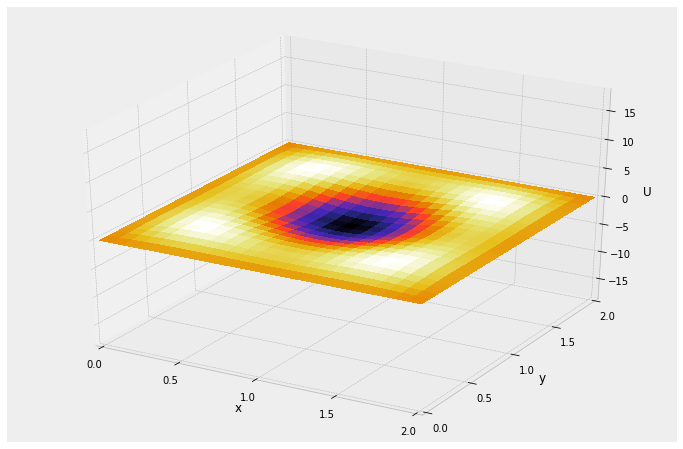

paso: 10.0 t= 0.285


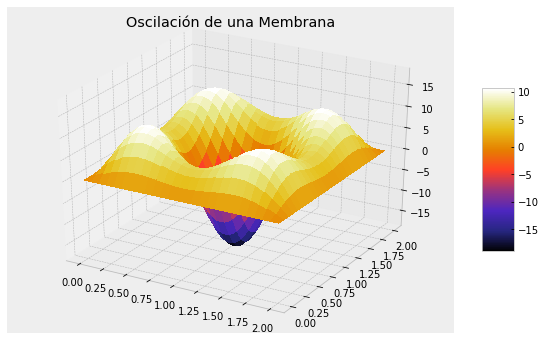

paso: 20.0 t= 0.585


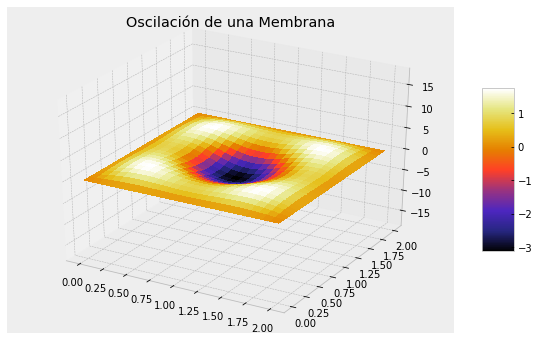

paso: 30.0 t= 0.885


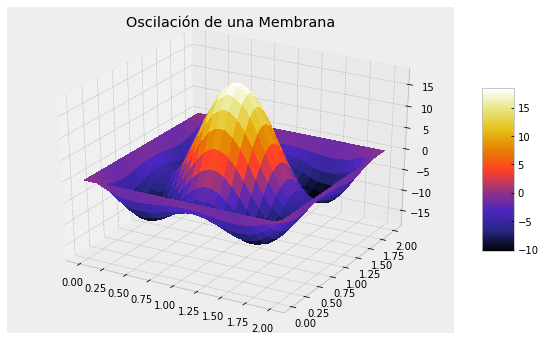

paso: 40.0 t= 1.185


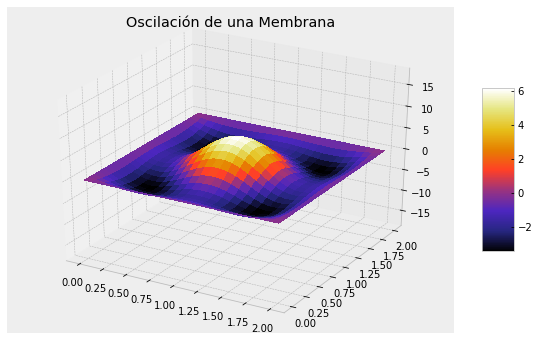

paso: 50.0 t= 1.4849999999999999


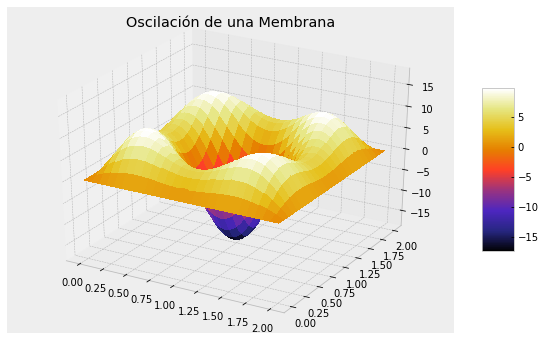

paso: 60.0 t= 1.785


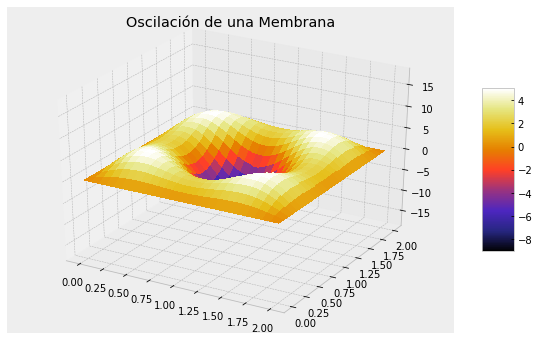

paso: 70.0 t= 2.085


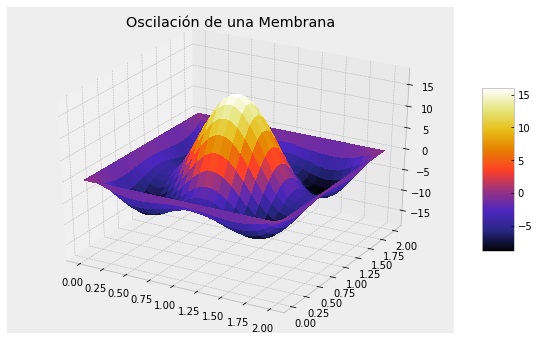

paso: 80.0 t= 2.385


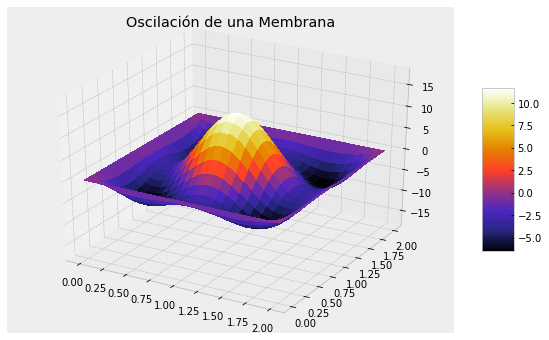

paso: 90.0 t= 2.685


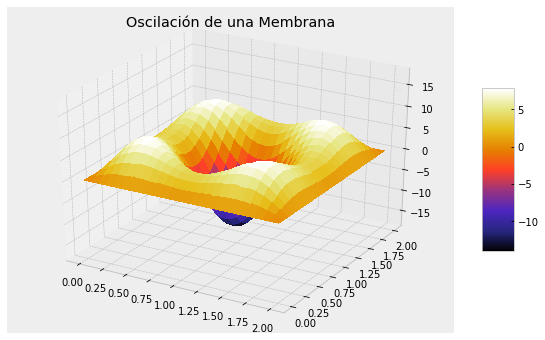

paso: 100.0 t= 2.985


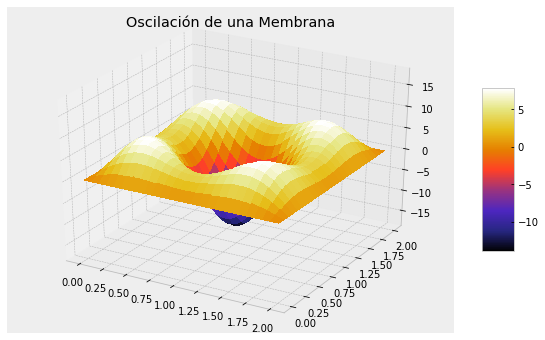

In [9]:
# Se define la Clase general que incluye todas las funciones
class WaveEquationFD:
    
    def __init__(self, N, D, Mx, My):
        self.N = N
        print('N:',N)
        self.D = D
        print('D:',D)
        self.Mx = Mx
        print('Mx:',Mx)
        self.My = My
        print('My',My)
        self.tend = 6
        self.xmin = 0
        self.xmax = 2
        self.ymin = 0
        self.ymax = 2
        self.initialization()
        self.eqnApprox()
           
    def initialization(self):
        self.dx = (self.xmax - self.xmin)/self.Mx
        self.dy = (self.ymax - self.ymin)/self.My
        print('dx,dy;',self.dx,self.dy)
        
        self.x = np.arange(self.xmin, self.xmax+self.dx, self.dx)
        self.y = np.arange(self.ymin, self.ymax+self.dy, self.dy)
        
        #----- Initial condition -----#
        self.u0 = lambda r, s: np.sin(3*np.pi*r/2)*np.sin(np.pi*s/2) \
                                    + np.sin(np.pi*r/2)*np.sin(3*np.pi*s/2) 
        
        #----- Initial velocity -----#
        self.v0 = lambda a, b: 0
        
        #----- Boundary conditions -----#
        self.bxyt = lambda left, right, time: 0
        
        self.dt = (self.tend - 0)/self.N
        self.t = np.arange(0, self.tend+self.dt/2, self.dt)
        
        # Assertion for the condition of r < 1, for stability
        r = 4*self.D*self.dt**2/(self.dx**2+self.dy**2);
        assert r < 1, "r is bigger than 1!"

            
    def eqnApprox(self):
        #----- Approximation equation properties -----#
        self.rx = self.D*self.dt**2/self.dx**2
        self.ry = self.D*self.dt**2/self.dy**2
        self.rxy1 = 1 - self.rx - self.ry 
        self.rxy2 = self.rxy1*2

        #----- Initialization matrix u for solution -----#
        self.u = np.zeros((self.Mx+1, self.My+1))
        self.ut = np.zeros((self.Mx+1, self.My+1))
        self.u_1 = self.u.copy()
        
        #----- Fills initial condition and initial velocity -----#
        for j in range(1, self.Mx):
            for i in range(1, self.My):
                self.u[i,j] = self.u0(self.x[i], self.y[j])
                self.ut[i,j] = self.v0(self.x[i], self.y[j])
        
    
    def solve_and_animate(self):
        
        u_2 = np.zeros((self.Mx+1, self.My+1))
        
        xx, yy = np.meshgrid(self.x, self.y)
         
        fig = plt.figure(figsize=(12,8))        
        ax = fig.add_subplot(111, projection='3d')
        #ax = plt.axes(projection ='3d')
        
        wframe = None
        
        k = 0
        nsteps = self.N
        print('nsteps:',nsteps)
        
        while k < nsteps:
            if wframe:
                ax.collections.remove(wframe)
                
            self.t = k*self.dt
            
            #----- Fills in boundary condition along y-axis (vertical, columns 0 and Mx) -----#
            for i in range(self.My+1):
                self.u[i, 0] = self.bxyt(self.x[0], self.y[i], self.t)
                self.u[i, self.Mx] = self.bxyt(self.x[self.Mx], self.y[i], self.t)
                
            for j in range(self.Mx+1):
                self.u[0, j] = self.bxyt(self.x[j], self.y[0], self.t)
                self.u[self.My, j] = self.bxyt(self.x[j], self.y[self.My], self.t)
                
            if k == 0:
                for j in range(1, self.My):
                    for i in range(1, self.Mx):
                        self.u[i,j] = 0.5*(self.rx*(self.u_1[i-1,j] + self.u_1[i+1,j])) \
                                + 0.5*(self.ry*(self.u_1[i,j-1] + self.u_1[i,j+1])) \
                                + self.rxy1*self.u[i,j] + self.dt*self.ut[i,j]
            else:
                for j in range(1, self.My):
                    for i in range(1, self.Mx):
                        self.u[i,j] = self.rx*(self.u_1[i-1,j] + self.u_1[i+1,j]) \
                            + self.ry*(self.u_1[i,j-1] + self.u_1[i,j+1]) \
                            + self.rxy2*self.u[i,j] - u_2[i,j]
                            
            u_2 = self.u_1.copy()
            self.u_1 = self.u.copy()

            wframe = ax.plot_surface(xx, yy, self.u, cmap=cm.CMRmap, linewidth=2, 
                    antialiased=False)
            
            ax.set_xlim3d(0, 2.0)
            ax.set_ylim3d(0, 2.0)
            ax.set_zlim3d(-18, 18)
            
            ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0])
            ax.set_yticks([0, 0.5, 1.0, 1.5, 2.0])
            
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("U")
            
            plt.pause(0.05)
            k += 0.5
            
            # Sección añadida para hacer gráficas cada 15 pasos 
            if (k < 101 and k%10 == 0):
                print('paso:',k, 't=', self.t)
                # Creating figure
                fig2 = plt.figure(figsize =(10, 6))
                ax2 = plt.axes(projection ='3d')
                # Creating color map
                my_cmap = plt.get_cmap('coolwarm')
                # Creating plot
                surf = ax2.plot_surface(xx, yy, self.u, cmap=cm.CMRmap, linewidth=2, 
                    antialiased=False)
                fig.colorbar(surf, ax = ax2,
                    shrink = 0.5, aspect = 5)
                ax2.set_zlim3d(-18,18)
                ax2.set_title('Oscilación de una Membrana')
                # show plot
                plt.show()

# Se definen los parámetros con los que se va a ejecutar el código     
# N pasos de integración, parámetro de estabilidad < 0.5, Num.Puntos x, Núm.Puntos y

def main():
    simulator = WaveEquationFD(200, 0.25, 50, 50)
    simulator.solve_and_animate() 
    plt.show()
    
if __name__ == "__main__":
    main()